# Lending Club Case Study

## Introduction

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Initial Data Analysis

In [197]:
# Read the dataset and check the first five rows
df = pd.read_csv("loan.csv")
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [198]:
# Check the shape, info and types of columns of the dataframe
df.shape

(39717, 111)

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [200]:
df.dtypes

id                              int64
member_id                       int64
loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
                               ...   
tax_liens                     float64
tot_hi_cred_lim               float64
total_bal_ex_mort             float64
total_bc_limit                float64
total_il_high_credit_limit    float64
Length: 111, dtype: object

## Data Handling and Cleaning

#### Missing Value Treatment

In [201]:
# Check which columns have null values
df.isnull().sum().sort_values(ascending=False)

verification_status_joint    39717
annual_inc_joint             39717
mo_sin_old_rev_tl_op         39717
mo_sin_old_il_acct           39717
bc_util                      39717
                             ...  
delinq_amnt                      0
policy_code                      0
earliest_cr_line                 0
delinq_2yrs                      0
id                               0
Length: 111, dtype: int64

In [202]:
# Drop the columns that are completely empty
df.dropna(axis = 1, how = 'all', inplace = True)
df.shape

(39717, 57)

In [205]:
# Check the number of nulls again
df.isnull().sum().sort_values(ascending=False)

next_pymnt_d                  38577
mths_since_last_record        36931
mths_since_last_delinq        25682
desc                          12942
emp_title                      2459
emp_length                     1075
pub_rec_bankruptcies            697
last_pymnt_d                     71
chargeoff_within_12_mths         56
collections_12_mths_ex_med       56
revol_util                       50
tax_liens                        39
title                            11
last_credit_pull_d                2
home_ownership                    0
int_rate                          0
out_prncp_inv                     0
total_pymnt                       0
total_pymnt_inv                   0
total_rec_prncp                   0
total_rec_int                     0
total_rec_late_fee                0
recoveries                        0
collection_recovery_fee           0
term                              0
last_pymnt_amnt                   0
initial_list_status               0
funded_amnt_inv             

In [206]:
# Dropping the columns with more than 20% missing values
df = df.dropna(thresh=int(0.8*len(df)), axis=1)
df.shape

(39717, 53)

#### Check and remove columns with single values

In [207]:
cols_to_remove = [col for col in df.columns if df[col].nunique() == 1]

df.drop(columns=cols_to_remove, inplace=True)
df.shape

(39717, 44)

#### Check for duplicated rows

In [209]:
df.duplicated().sum()

0

#### Dropping columns irrelevant to our analysis


In [210]:
# The below columns don't provide any necessary data to predict loan default. In other
# words, these columns don't act as driver variables.
columns_to_drop = [
 'collection_recovery_fee', # Post charge off fee. Not relevant
 'emp_title', # Employment title. Doesn't help analysis
 'funded_amnt',
 'funded_amnt_inv',
 'inq_last_6mths', # Number of inquiries last 6 months. Doesn't help analysis
 'last_credit_pull_d', 
 'last_pymnt_amnt',
 'last_pymnt_d', 
 'member_id', # Not required
 'open_acc',
 'out_prncp',
 'out_prncp_inv',
 'pub_rec',
 'recoveries', 
 'revol_bal',
 'revol_util',
 'title', # User entered values
 'total_pymnt', # This and below aren't strong enough driver variables for credit defaults
 'total_pymnt_inv', 
 'total_rec_int',
 'total_rec_late_fee',
 'total_rec_prncp', 
 'url', # Redundant as the url is just https://lendingclub.com/browse/loanDetail.action? followed by loan_id
 'zip_code' # Too granular. Can use the address field instead. 
]

df.drop(columns=columns_to_drop, inplace=True)
df.shape

(39717, 20)

#### Dropping "Current" loan_status rows

In [211]:
# We are dropping all the rows that have the 'Current' loan status as these entries don't give us any
# information that suggests whether a loan will default or not
df = df[df.loan_status != 'Current']
df.shape

(38577, 20)

#### Data conversions


In [212]:
# Converting "term" to an integer
df.term = df.term.map(lambda x: int(x.rstrip(" months")))
df.term

0        36
1        60
2        36
3        36
5        36
         ..
39712    36
39713    36
39714    36
39715    36
39716    36
Name: term, Length: 38577, dtype: int64

In [213]:
# Converting issue_d and earliest_cr_line to datetime
df.issue_d = pd.to_datetime(df.issue_d, format="%b-%y")
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format="%b-%y")

In [214]:
def emp_length_to_int(x):
    if pd.isna(x):
        return np.nan
    elif x == '< 1 year':
        return 0
    elif x == '10+ years':
        return 10
    else:
        return int(x.split()[0])

# Use the map function to replace values in the 'emp_length' column
df.emp_length = df.emp_length.apply(emp_length_to_int)

In [215]:
# Convert int_rate to a float
df.int_rate = df.int_rate.map(lambda x: float(x.rstrip("%")))

In [216]:
# Standardize home_ownership such that NONE ---> OTHER
df.home_ownership.replace("NONE", "OTHER", inplace=True)
df.home_ownership.value_counts()

home_ownership
RENT        18480
MORTGAGE    17021
OWN          2975
OTHER         101
Name: count, dtype: int64

In [217]:
# Standardize verification_status such that "Source Verified" ---> "Verified"
df.verification_status.replace("Source Verified", "Verified", inplace=True)

#### Imputing missing values

In [218]:
# Imputing missing values for pub_rec_bankruptcies
df.pub_rec_bankruptcies.fillna(0, inplace=True)

In [220]:
# Inputing missing values for emp_length. We will impute 70% of the data using the mode
# and 30% of the data using random sampling.
mode_emp_length = df.emp_length.mode()[0]
unique_emp_lengths = df.emp_length.dropna().unique()

def impute_emp_length(x):
    if pd.isna(x):
        # 70% chance of using the mode, 30% chance of random sampling
        if np.random.random() < 0.7:
            return mode_emp_length
        else:
            return np.random.choice(unique_emp_lengths)
    return x

# Step 5: Apply the imputation
df.emp_length = df.emp_length.apply(impute_emp_length)

#### Handling Outliers

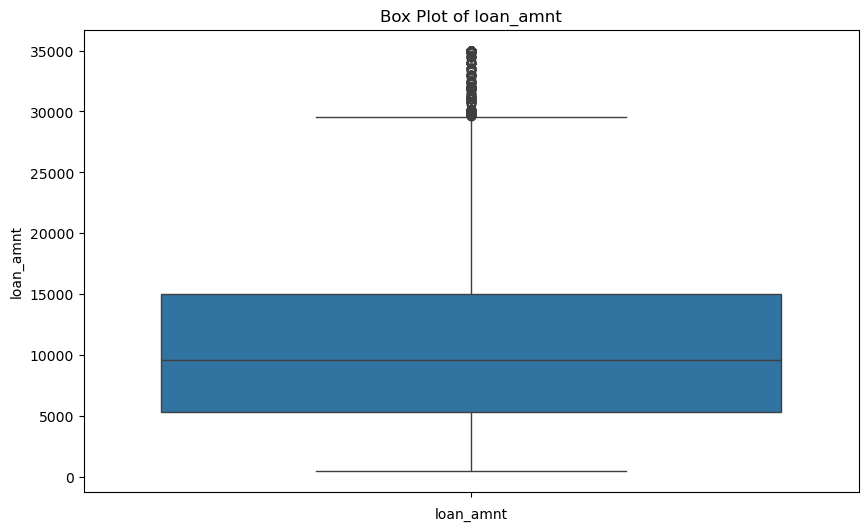

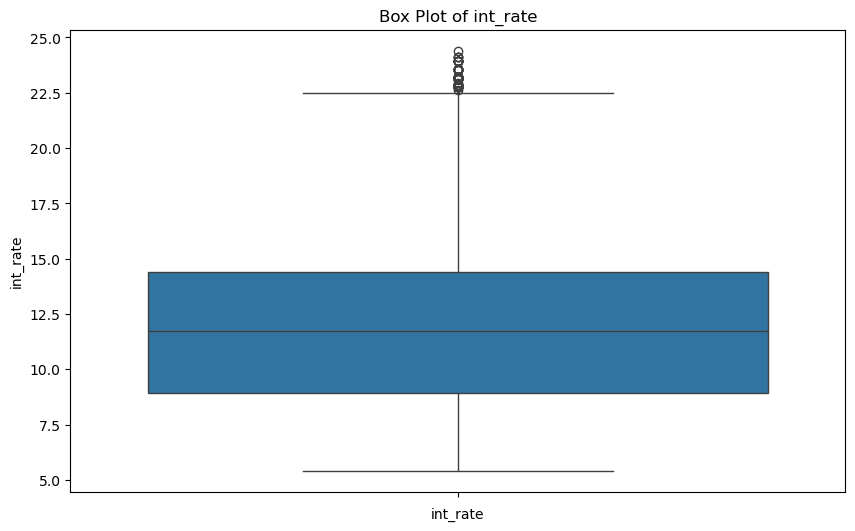

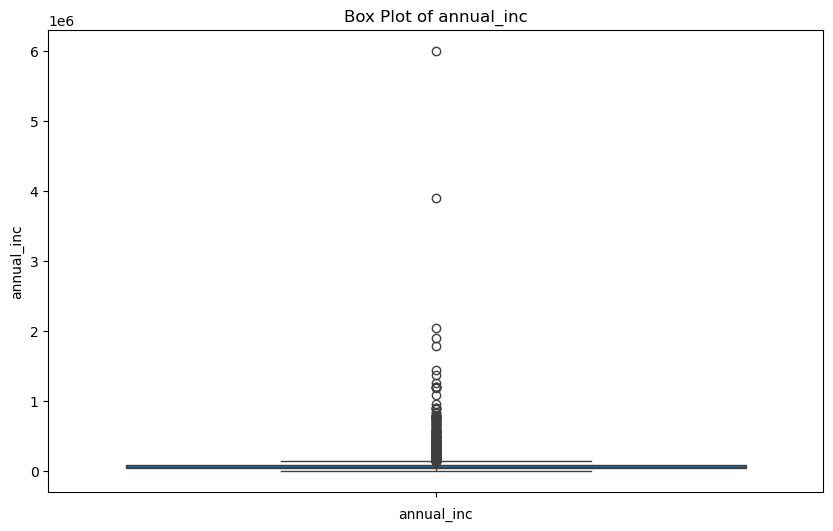

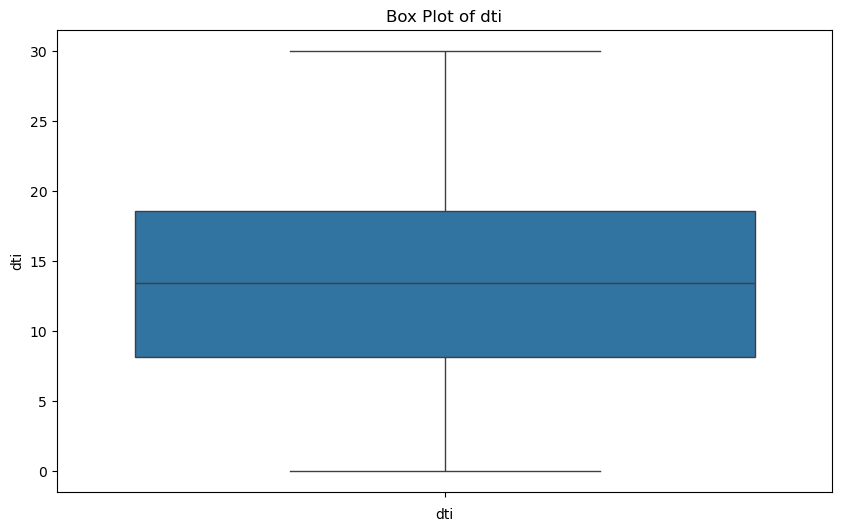

In [195]:
# Checking for outliers in loan_amount, int_rate, annual_inc, dti
cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti']

# Box plots for numerical variables
for var in cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(df[var])
    plt.title(f'Box Plot of {var}')
    plt.xlabel(var)
    plt.show()

plt.show()


Clearly, there are outliers in annual_inc. Let's treat these using the IQR method

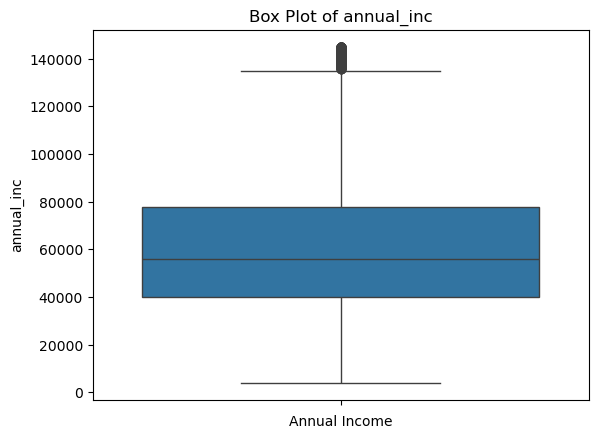

In [196]:
Q1 = df.annual_inc.quantile(0.25)
Q3 = df.annual_inc.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df.annual_inc >= lower_bound) & (df.annual_inc <= upper_bound)]


plt.title(f'Box Plot of annual_inc')
plt.xlabel('Annual Income')
sns.boxplot(df.annual_inc)
plt.show()

In [221]:
# Sanity check to ensure that our data has no null values anymore.
df.isnull().sum()

id                      0
loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
addr_state              0
dti                     0
delinq_2yrs             0
earliest_cr_line        0
total_acc               0
pub_rec_bankruptcies    0
dtype: int64

#### Cleaned up dataset


In [222]:
df

,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,total_acc,pub_rec_bankruptcies
0,1077501,5000,36,10.65,162.87,B,B2,10.0,RENT,24000.0,Verified,2011-12-01,Fully Paid,credit_card,AZ,27.65,0,1985-01-01,9,0.0
1,1077430,2500,60,15.27,59.83,C,C4,0.0,RENT,30000.0,Verified,2011-12-01,Charged Off,car,GA,1.00,0,1999-04-01,4,0.0
2,1077175,2400,36,15.96,84.33,C,C5,10.0,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,small_business,IL,8.72,0,2001-11-01,10,0.0
3,1076863,10000,36,13.49,339.31,C,C1,10.0,RENT,49200.0,Verified,2011-12-01,Fully Paid,other,CA,20.00,0,1996-02-01,37,0.0
5,1075269,5000,36,7.90,156.46,A,A4,3.0,RENT,36000.0,Verified,2011-12-01,Fully Paid,wedding,AZ,11.20,0,2004-11-01,12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39712,92187,2500,36,8.07,78.42,A,A4,4.0,MORTGAGE,110000.0,Not Verified,2007-07-01,Fully Paid,home_improvement,CO,11.33,0,1990-11-01,40,0.0
39713,90665,8500,36,10.28,275.38,C,C1,3.0,RENT,18000.0,Not Verified,2007-07-01,Fully Paid,credit_card,NC,6.40,1,1986-12-01,9,0.0
39714,90395,5000,36,8.07,156.84,A,A4,0.0,MORTGAGE,100000.0,Not Verified,2007-07-01,Fully Paid,debt_consolidation,MA,2.30,0,1998-10-01,20,0.0
39715,90376,5000,36,7.43,155.38,A,A2,0.0,MORTGAGE,200000.0,Not Verified,2007-07-01,Fully Paid,other,MD,3.72,0,1988-11-01,26,0.0
